<a href="https://colab.research.google.com/github/ereinha/PMAE/blob/main/UCI_Higgs_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
# # Uncomment this cell to store files to your personal google drive
# from google.colab import drive
# drive.mount('/content/drive')
# %cd drive/MyDrive

In [2]:
!git clone https://github.com/ereinha/PMAE

In [3]:
%cd PMAE

/content/drive/MyDrive/PMAE


In [4]:
!pwd

/content/drive/MyDrive/PMAE


In [5]:
import train
import utils
import test_and_plot
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import json
from models import classifier, pmae
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

In [6]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [7]:
# Download the files from UCI ML repository
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
!gzip -d HIGGS.csv.gz

In [8]:
# Read in the csv
data = pd.read_csv('./HIGGS.csv', header=None)

In [9]:
# Split the data and labels
X = data.iloc[:,1:]
y = data.iloc[:,0]

In [11]:
# Get the inputs and outputs
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

In [12]:
# Grab only the first 500k items
X = X[:500000]
y = y[:500000]

In [13]:
print(X.shape)

(500000, 28)


In [14]:
# Remove high level features and add 0 padding to line up related quantities
X = np.delete(X, obj=np.s_[X.shape[1]-7:X.shape[1]], axis=-1)
X = np.insert(X, obj=np.s_[3:4], values=0, axis=-1)
X = np.insert(X, obj=np.s_[5:6], values=0, axis=-1)
X = np.insert(X, obj=np.s_[7:8], values=0, axis=-1)

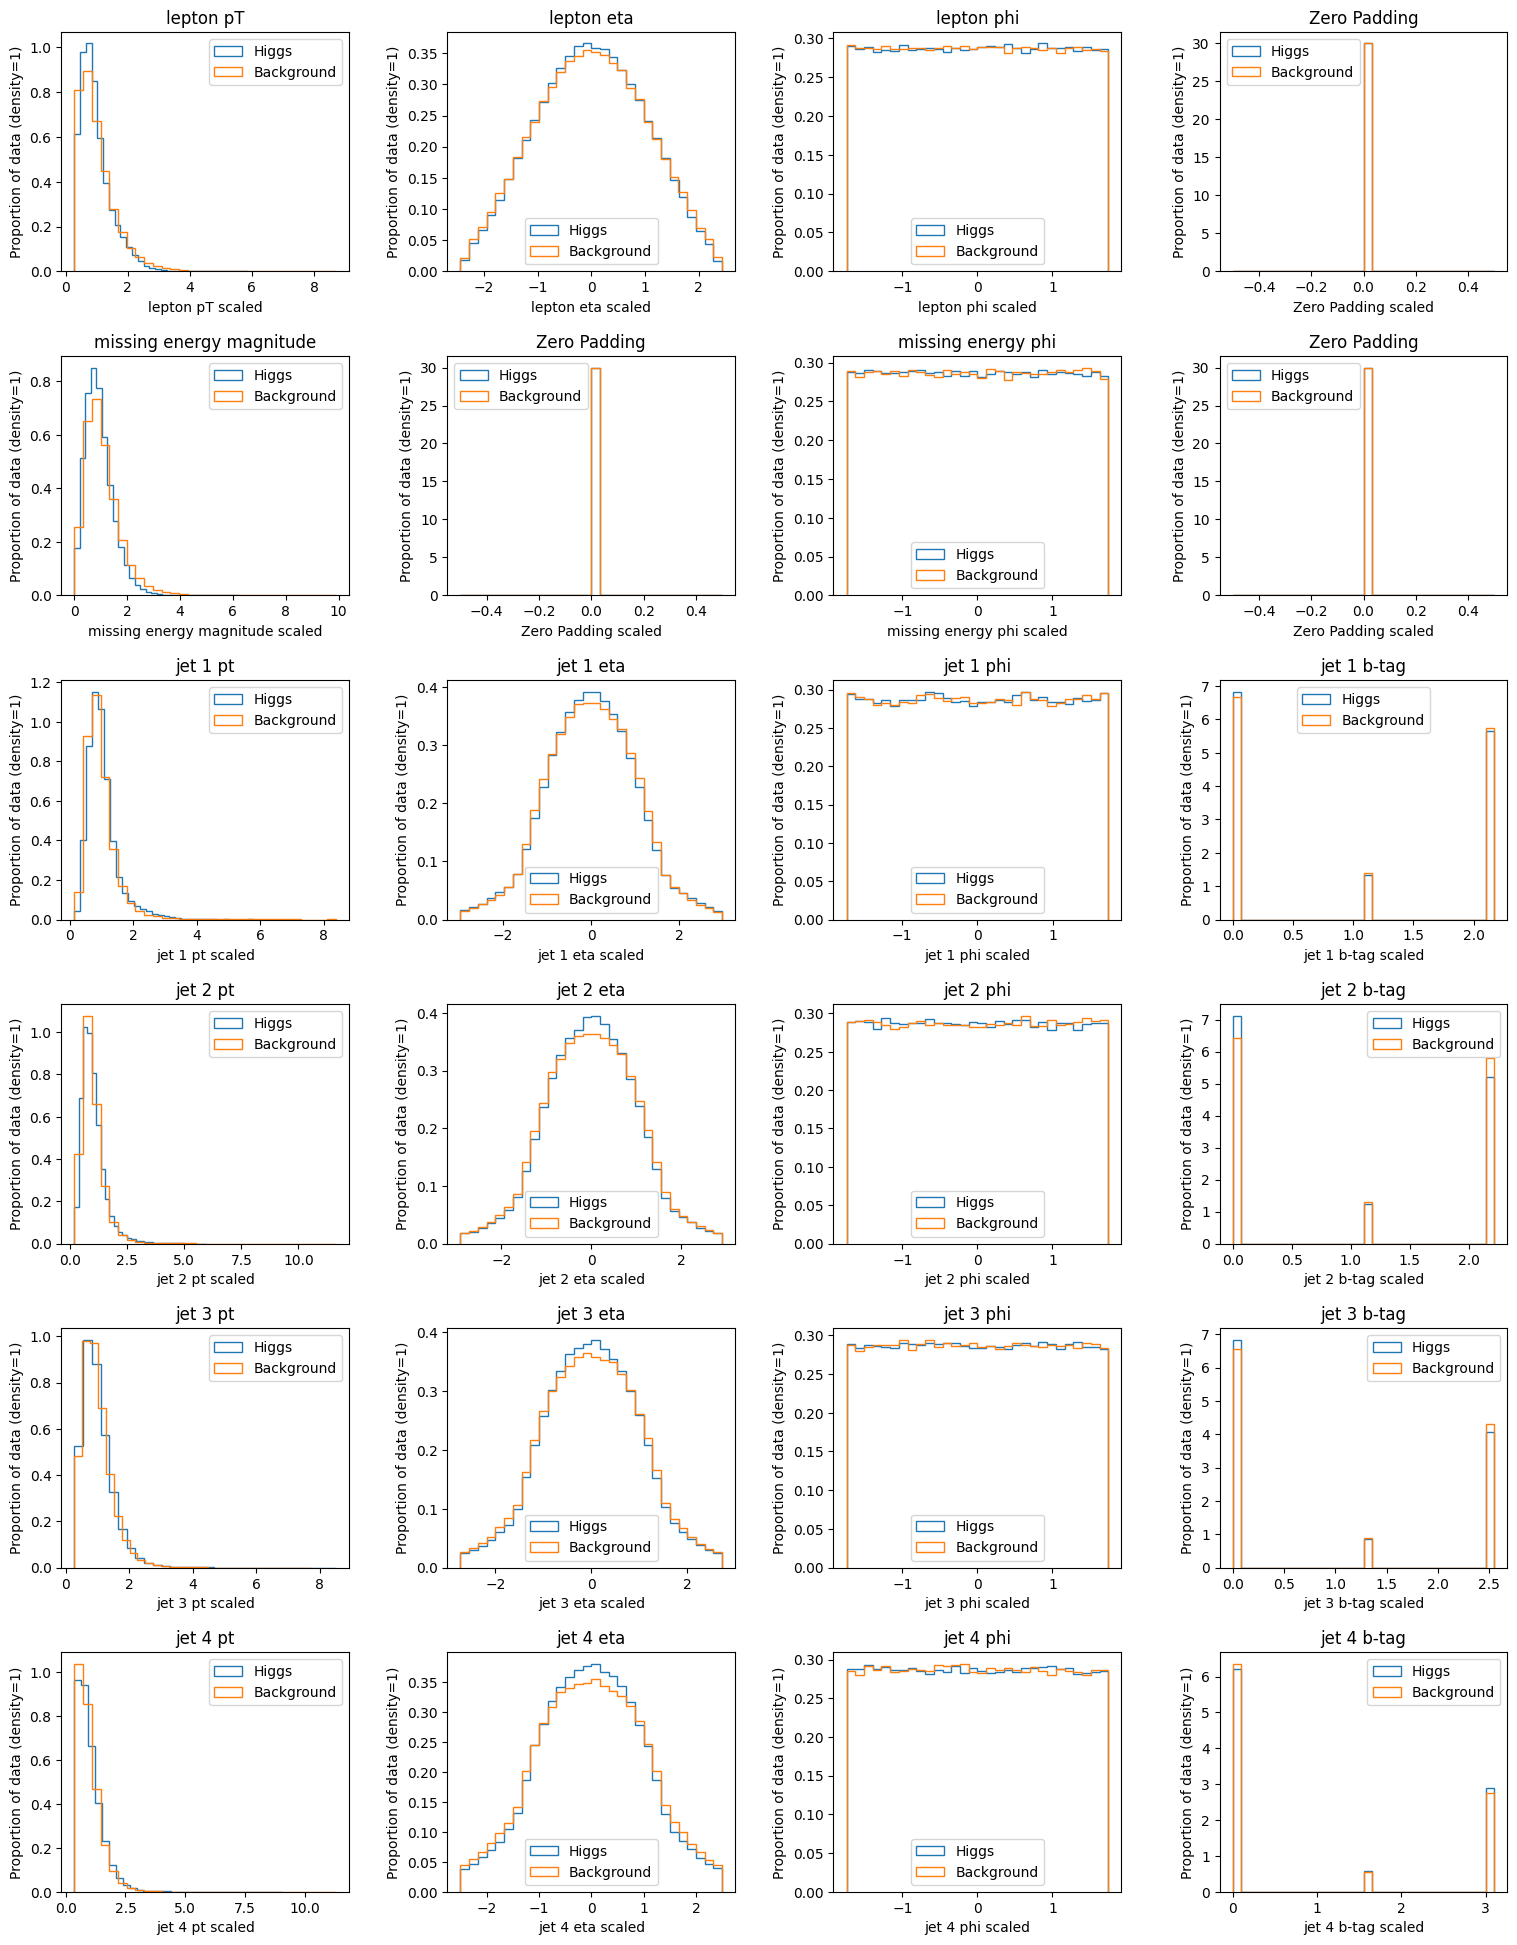

In [15]:
# Visualizing the data
names = ["lepton pT", "lepton eta", "lepton phi", "Zero Padding",
         "missing energy magnitude", "Zero Padding", "missing energy phi", "Zero Padding",
         "jet 1 pt", "jet 1 eta", "jet 1 phi", "jet 1 b-tag",
         "jet 2 pt", "jet 2 eta", "jet 2 phi", "jet 2 b-tag",
         "jet 3 pt", "jet 3 eta", "jet 3 phi", "jet 3 b-tag",
         "jet 4 pt", "jet 4 eta", "jet 4 phi", "jet 4 b-tag"]

fig, axes = plt.subplots(6,4, figsize=(16,20))
fig.tight_layout(pad=4)

X_higgs = X[y==1]
X_nohiggs = X[y==0]
y_higgs = y[y==1]
y_nohiggs = y[y==0]

for i in range(len(axes)):
    for j in range(len(axes[0])):
        axes[i,j].hist(X_higgs[:,i*4+j], histtype='step', stacked=False, density=1, bins=30, label='Higgs')
        axes[i,j].hist(X_nohiggs[:,i*4+j], histtype='step', stacked=False, density=1, bins=30, label='Background')
        axes[i,j].set_title(names[i*4+j])
        axes[i,j].set_xlabel(names[i*4+j] + ' scaled')
        axes[i,j].legend()
        axes[i,j].set_ylabel("Proportion of data (density=1)")
plt.show()

In [16]:
del X
del y

In [17]:
print(len(X_higgs))

264703


In [18]:
print(len(X_nohiggs))

235297


In [19]:
labels_hh = np.ones(len(X_higgs))
labels_tt = np.zeros(len(X_nohiggs))

In [20]:
X_hh_train, X_val1, labels_hh_train, labels_val1 = train_test_split(X_higgs, labels_hh, test_size=0.2, random_state=42)
X_hh_val, X_hh_test, labels_hh_val, labels_hh_test = train_test_split(X_val1, labels_val1, test_size=0.5, random_state=42)

In [21]:
del X_higgs

In [22]:
# Normalize data
x_scaler = StandardScaler()
X_hh_train = x_scaler.fit_transform(X_hh_train)
X_hh_val = x_scaler.transform(X_hh_val)
X_hh_test = x_scaler.transform(X_hh_test)
X_nohiggs = x_scaler.transform(X_nohiggs)

In [23]:
X_tt_train, X_val1, labels_tt_train, labels_val1 = train_test_split(X_nohiggs, labels_tt, test_size=0.2, random_state=42)
X_tt_val, X_tt_test, labels_tt_val, labels_tt_test = train_test_split(X_val1, labels_val1, test_size=0.5, random_state=42)

In [24]:
del X_nohiggs

In [25]:
print(np.shape(X_hh_train), np.shape(X_tt_train))

(211762, 24) (188237, 24)


In [26]:
X_hh_train = X_hh_train.reshape(X_hh_train.shape[0],6,4)
X_hh_val = X_hh_val.reshape(X_hh_val.shape[0],6,4)
X_hh_test = X_hh_test.reshape(X_hh_test.shape[0],6,4)
X_tt_train = X_tt_train.reshape(X_tt_train.shape[0],6,4)
X_tt_val = X_tt_val.reshape(X_tt_val.shape[0],6,4)
X_tt_test = X_tt_test.reshape(X_tt_test.shape[0],6,4)

phi_limit = np.max((abs(np.max(X_hh_train[:,0,2])), abs(np.min(X_hh_train[:,0,2])))) # Only need one value assuming phi distrubtions are all uniform
lower_pt_limit = [np.min(X_hh_train[:,i,0]) for i in range(6)]

In [27]:
def get_f_alphas(arr):
    min = np.min(arr)
    max = np.max(arr)
    return [len(arr[arr==max])/(len(arr[arr==max])+len(arr[arr==min])), len(arr[arr==min])/(len(arr[arr==max])+len(arr[arr==min]))]

In [28]:
f_alphas = []
for i in range(6):
    f_alphas.append(get_f_alphas(X_hh_train[:,i,3]))
f_alphas = np.array(f_alphas)

In [29]:
print(f_alphas.shape)

(6, 2)


In [30]:
f_alphas[:,1] *= 1.

In [31]:
def useful_b_tag(data):
    unique_values = np.unique(data)

    value_to_int = {value: i for i, value in enumerate(unique_values)}

    discretized_data = np.vectorize(value_to_int.__getitem__)(data)

    # initialize an empty array of shape (total_size, 2)
    new_array = np.zeros((len(discretized_data), 2))

    # fill the new array based on your conditions
    for i, val in enumerate(discretized_data):
        if val == 0:
            new_array[i] = [1, 0]
        elif val == 1:
            new_array[i] = [0.5, 0.5]
        else:
            new_array[i] = [0, 1]

    return new_array

In [32]:
def expand_and_append(array):
    array = np.append(array, np.zeros((array.shape[0], array.shape[1], 1)), axis=2)
    return array

In [33]:
X_hh_train = expand_and_append(X_hh_train)
X_hh_val = expand_and_append(X_hh_val)
X_hh_test = expand_and_append(X_hh_test)
X_tt_train = expand_and_append(X_tt_train)
X_tt_val = expand_and_append(X_tt_val)
X_tt_test = expand_and_append(X_tt_test)

for i in range(3,len(X_hh_train[0]),5):
    for j in range(6):
        X_hh_train[:,j,i:i+2] = useful_b_tag(X_hh_train[:,j,i])
        X_hh_val[:,j,i:i+2] = useful_b_tag(X_hh_val[:,j,i])
        X_hh_test[:,j,i:i+2] = useful_b_tag(X_hh_test[:,j,i])
        X_tt_train[:,j,i:i+2] = useful_b_tag(X_tt_train[:,j,i])
        X_tt_val[:,j,i:i+2] = useful_b_tag(X_tt_val[:,j,i])
        X_tt_test[:,j,i:i+2] = useful_b_tag(X_tt_test[:,j,i])

In [34]:
print(X_hh_train.shape)

(211762, 6, 5)


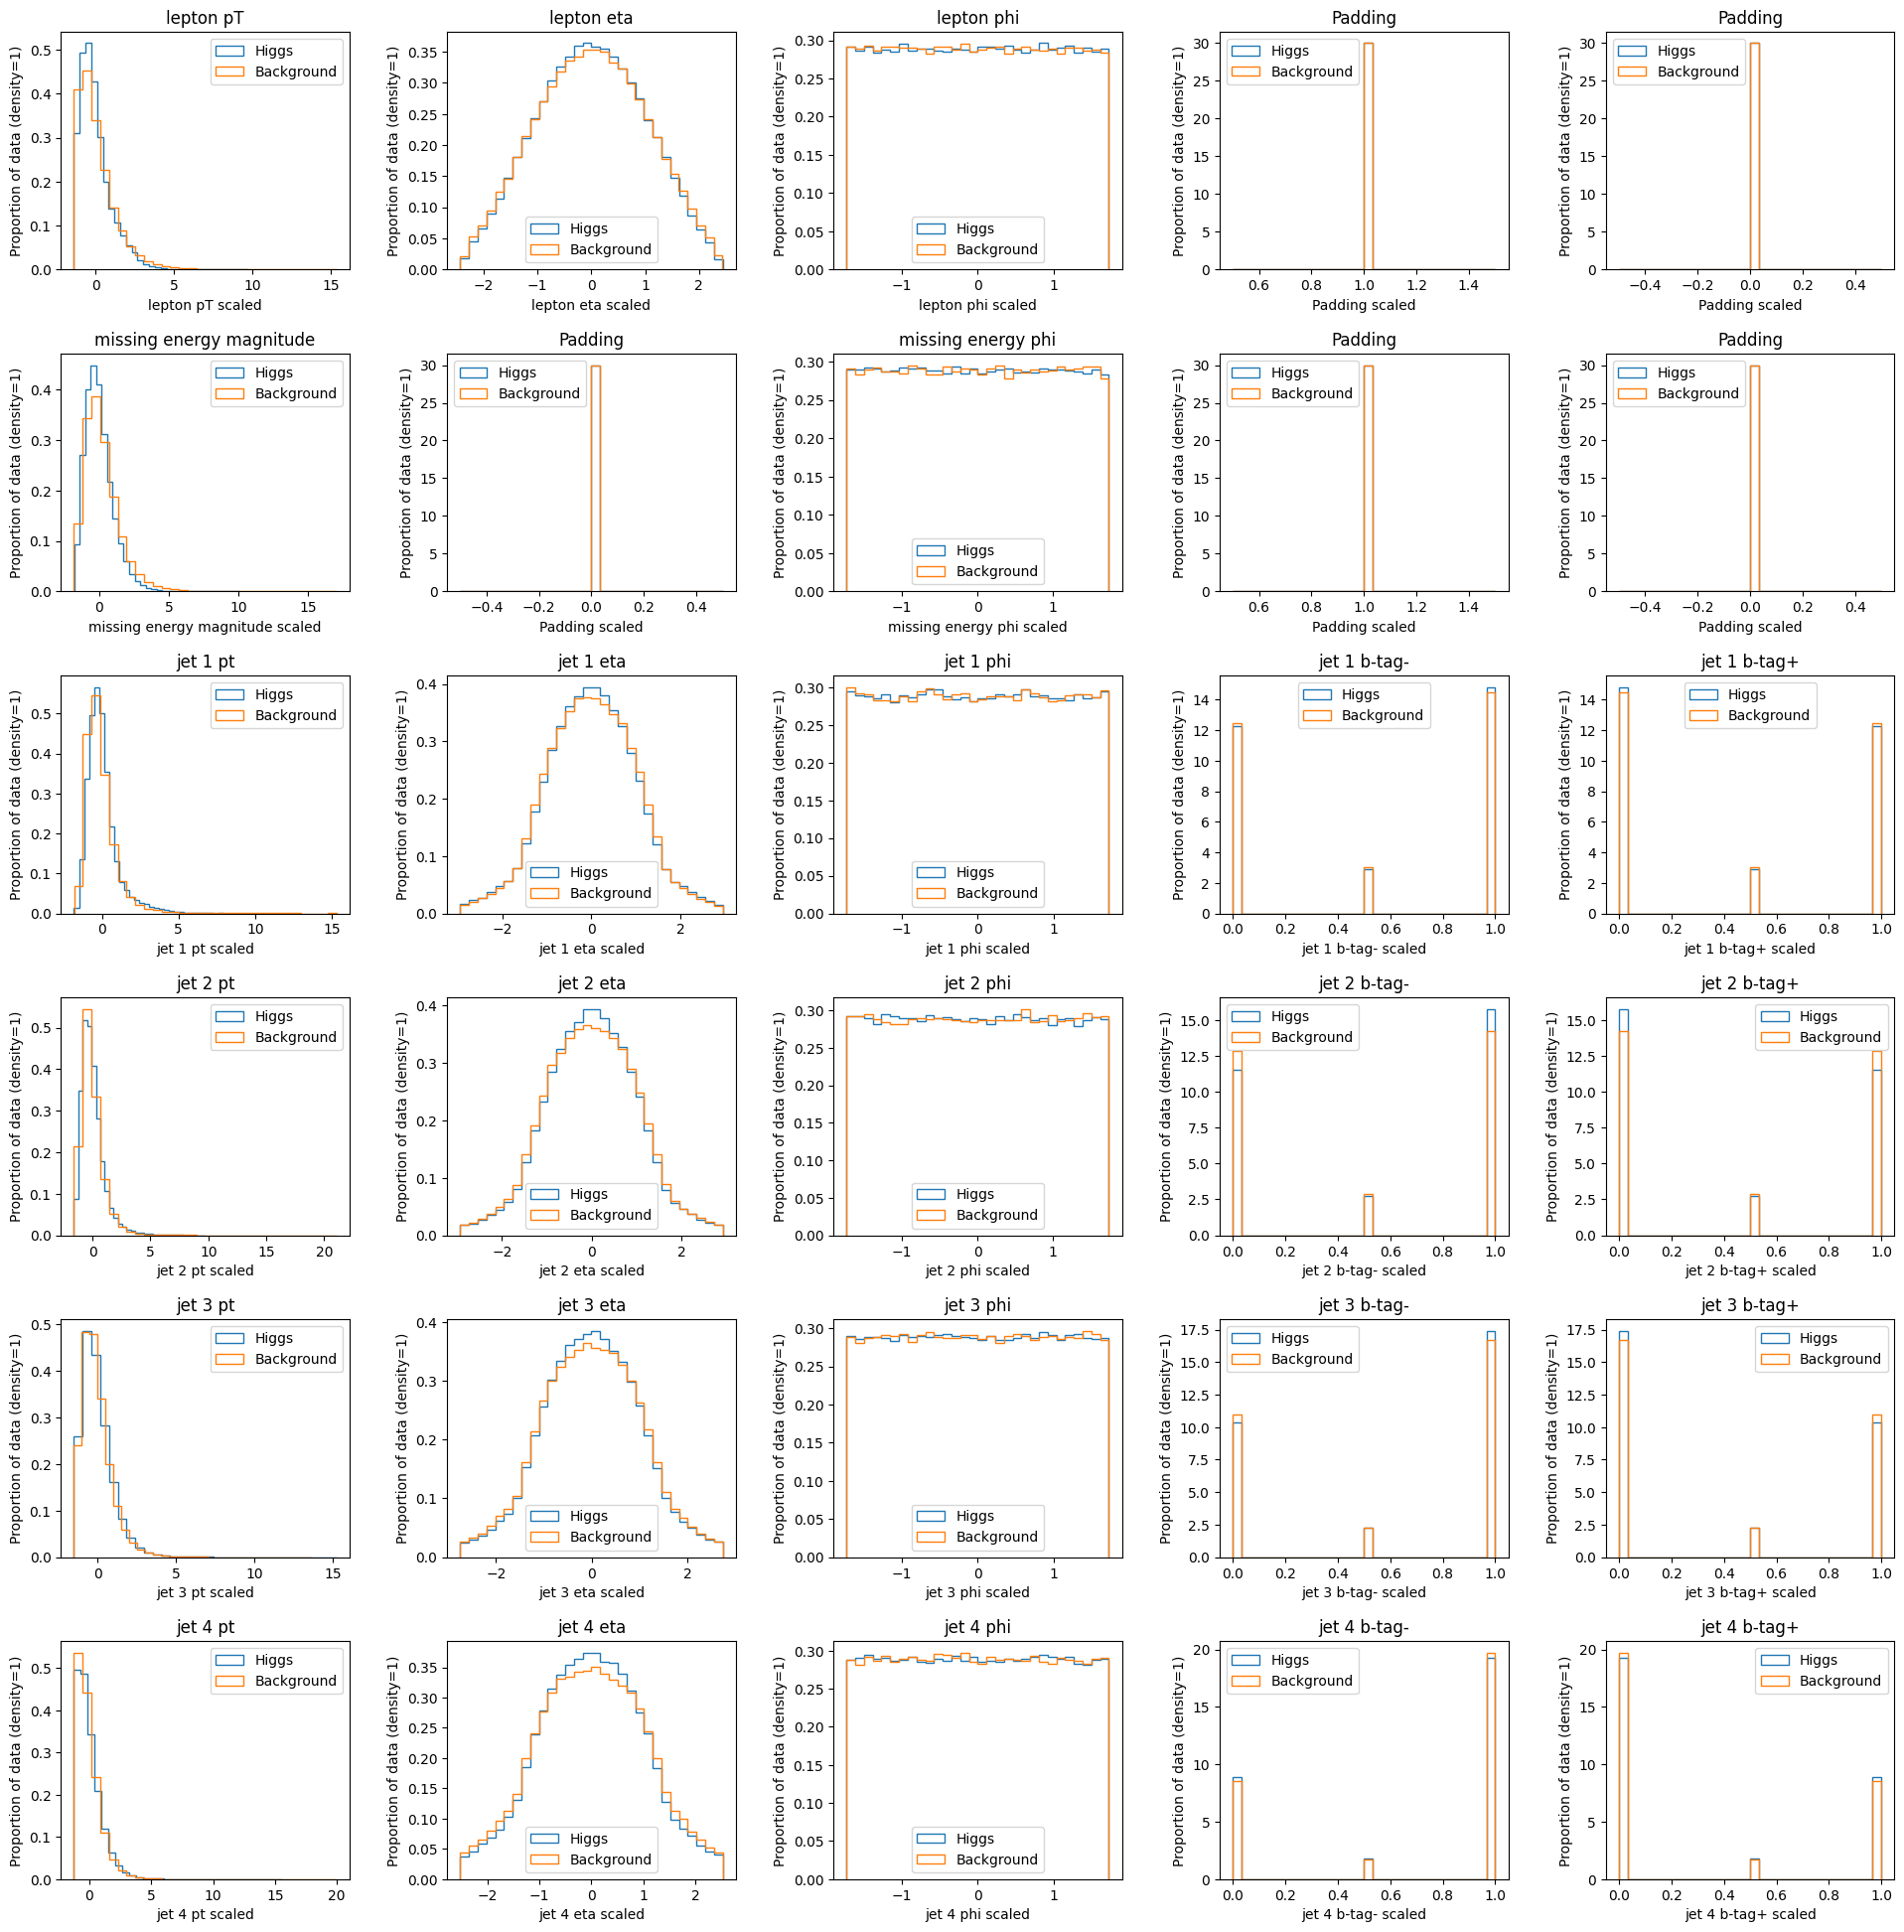

In [35]:
names = ["lepton pT", "lepton eta", "lepton phi", "Padding", "Padding",
         "missing energy magnitude", "Padding", "missing energy phi", "Padding", "Padding",
         "jet 1 pt", "jet 1 eta", "jet 1 phi", "jet 1 b-tag-", "jet 1 b-tag+",
         "jet 2 pt", "jet 2 eta", "jet 2 phi", "jet 2 b-tag-", "jet 2 b-tag+",
         "jet 3 pt", "jet 3 eta", "jet 3 phi", "jet 3 b-tag-", "jet 3 b-tag+",
         "jet 4 pt", "jet 4 eta", "jet 4 phi", "jet 4 b-tag-", "jet 4 b-tag+",]

fig, axes = plt.subplots(6,5, figsize=(20,20))
fig.tight_layout(pad=4)

for i in range(len(axes)):
    for j in range(len(axes[0])):
        axes[i,j].hist(X_hh_train[:,i,j], histtype='step', stacked=False, density=1, bins=30, label='Higgs')
        axes[i,j].hist(X_tt_train[:,i,j], histtype='step', stacked=False, density=1, bins=30, label='Background')
        axes[i,j].set_title(names[i*5+j])
        axes[i,j].set_xlabel(names[i*5+j] + ' scaled')
        axes[i,j].legend()
        axes[i,j].set_ylabel("Proportion of data (density=1)")

In [36]:
X_train = np.append(X_hh_train, X_tt_train, axis=0)
del X_tt_train
X_val = np.append(X_hh_val, X_tt_val, axis=0)
del X_tt_val
X_test = np.append(X_hh_test, X_tt_test, axis=0)
del X_tt_test
labels_train = np.append(labels_hh_train, labels_tt_train, axis=0)
del labels_tt_train
labels_val = np.append(labels_hh_val, labels_tt_val, axis=0)
del labels_tt_val
labels_test = np.append(labels_hh_test, labels_tt_test, axis=0)
del labels_tt_test

In [37]:
# Load a config file from a json
with open('./configs/uci_higgs_config_demo.json', 'r') as f:
    config = json.load(f)

In [38]:
model_name = (
    f'Model_DM{config["d_model"]}_H{config["num_heads"]}_L{config["num_layers"]}'
    f'_F{config["d_ff"]}_DR{config["dropout"]}_B{config["batch_size"]}_T{config["test_batch_size"]}'
    f'_AE{config["ae_resume_epoch"]}_PC{config["pc_resume_epoch"]}_FC{config["fc_resume_epoch"]}'
    f'_NE{config["num_epochs"]}_ES{config["epochs_to_saturate"]}'
    f'_IM{config["init_momentum"]}_MM{config["max_momentum"]}_TILR{config["tae_init_lr"]}'
    f'_PCLR{config["pc_init_lr"]}_FCLR{config["fc_init_lr"]}_MSL{config["max_seq_len"]}_Mk{config["mask"]}'
    f'_A{config["alpha"]}_B{config["beta"]}_G{config["gamma"]}_D{config["delta"]}_OV{config["output_vars"]}'
    f'_WD{config["weight_decay"]}_MLR{config["min_lr"]}_LD{config["lr_decay"]}'
    f'_CIF{config["class_input_features"]}_CFD{config["class_ff_dim"]}'
)

In [39]:
# Set device to use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
# Instantiate the dataset and DataLoader
train_data = utils.DataLabelDataset(X_train, labels_train)
train_loader = DataLoader(train_data, batch_size=config["batch_size"], drop_last=True, shuffle=True,
                          pin_memory=True, num_workers=2, pin_memory_device=str(device))
hh_train_data = utils.DataLabelDataset(X_hh_train, labels_hh_train)
hh_train_loader = DataLoader(hh_train_data, batch_size=config["batch_size"], drop_last=True, shuffle=True,
                             pin_memory=True, num_workers=2, pin_memory_device=str(device))
val_data = utils.DataLabelDataset(X_val, labels_val)
val_loader = DataLoader(val_data, batch_size=config["test_batch_size"], shuffle=True)
hh_val_data = utils.DataLabelDataset(X_hh_val, labels_hh_val)
hh_val_loader = DataLoader(hh_val_data, batch_size=config["test_batch_size"], shuffle=True)
test_data = utils.DataLabelDataset(X_test, labels_test)
test_loader = DataLoader(test_data, batch_size=config["test_batch_size"], shuffle=False)
del X_hh_train
del X_hh_val
del labels_hh_train
del labels_hh_val

In [41]:
# Build the autoencoder model
tae = pmae.TransformerAutoencoder(config['d_model'], config['num_heads'], config['num_layers'], config['d_ff'], config['max_seq_len'], config['output_vars'], config['dropout'], device)
# Build classifier
partial_class = classifier.BinaryClassifier(config['class_input_features'], config['class_ff_dim'], config['dropout'])
# Build classifier
full_class = classifier.BinaryClassifier(config['class_input_features'], config['class_ff_dim'], config['dropout'])

In [42]:
# Send the models to gpu if possible
tae = tae.to(device)
partial_class = partial_class.to(device)
full_class = full_class.to(device)

In [43]:
# Assign the criterion
criterion = utils.custom_loss(phi_limit, config['alpha'], config['beta'], config['gamma'], config['delta'], lower_pt_limit, f_alphas, config['output_vars'])
criterion_2 = nn.BCELoss()

In [44]:
# Build the optimizers
optimizer = utils.SGDWithSaturatingMomentumAndDecay(tae.parameters(), lr=config['tae_init_lr'], momentum=config['init_momentum'], max_momentum=config['max_momentum'],
                                                    epochs_to_saturate=config['epochs_to_saturate'], batches_per_epoch=len(hh_train_loader), weight_decay=0,
                                                    lr_decay=config['lr_decay'], min_lr=config['min_lr'], resume_epoch=config['ae_resume_epoch'])
optimizer_2 = utils.SGDWithSaturatingMomentumAndDecay(partial_class.parameters(), lr=config['pc_init_lr'], momentum=config['init_momentum'],
                                                      max_momentum=config['max_momentum'],  epochs_to_saturate=config['epochs_to_saturate'],
                                                      batches_per_epoch=len(train_loader), weight_decay=config['weight_decay'], lr_decay=config['lr_decay'],
                                                      min_lr=config['min_lr'], resume_epoch=config['pc_resume_epoch'])
optimizer_3 = utils.SGDWithSaturatingMomentumAndDecay(full_class.parameters(), lr=config['fc_init_lr'], momentum=config['init_momentum'],
                                                      max_momentum=config['max_momentum'],  epochs_to_saturate=config['epochs_to_saturate'],
                                                      batches_per_epoch=len(train_loader), weight_decay=config['weight_decay'], lr_decay=config['lr_decay'],
                                                      min_lr=config['min_lr'], resume_epoch=config['fc_resume_epoch'])

In [45]:
# Train the autoencoder
val_loss_min = train.train(hh_train_loader, hh_val_loader, [tae], device, optimizer, criterion,
                           'autoencoder', config['output_vars'], zero_padded=[3,6,8], mask=config['mask'],
                           num_epochs=config['num_epochs']-config['ae_resume_epoch'],
                           save_path='./saved_models/uci_higgs', model_name=model_name)

In [46]:
# Build the autoencoder model
tae = pmae.TransformerAutoencoder(config['d_model'], config['num_heads'], config['num_layers'], config['d_ff'],
                                  config['max_seq_len'], config['output_vars'], config['dropout'], device)
tae.load_state_dict(torch.load('./saved_models/uci_higgs/TAE_best_' + model_name))
tae = tae.to(device)
for param in tae.parameters():
    param.requires_grad = False

In [48]:
# Train a partial-event classifier
val_loss_min = train.train(train_loader, val_loader, [tae, partial_class], device, optimizer_2, criterion_2,
                           'classifier partial', config['output_vars'], zero_padded=[3,6,8], mask=config['mask'],
                           num_epochs=config['num_epochs']-config['pc_resume_epoch'],
                           save_path='./saved_models/uci_higgs', model_name=model_name)

In [49]:
# Train a full event classifier
val_loss_min = train.train(train_loader, val_loader, [tae, full_class], device, optimizer_3, criterion_2,
                           'classifier full', config['output_vars'], zero_padded=[3,6,8], mask=config['mask'],
                           num_epochs=config['num_epochs']-config['fc_resume_epoch'],
                           save_path='./saved_models/uci_higgs', model_name=model_name)

In [50]:
# Parse a json config interpretation from a model name string
config = utils.parse_model_name(model_name)

In [51]:
# Build the autoencoder model
tae = pmae.TransformerAutoencoder(config['d_model'], config['num_heads'], config['num_layers'], config['d_ff'],
                                  config['max_seq_len'], config['output_vars'], config['dropout'], device)
tae.load_state_dict(torch.load('./saved_models/uci_higgs/TAE_best_' + model_name))
# Build classifier
partial_class = classifier.BinaryClassifier(config['class_input_features'], config['class_ff_dim'], config['dropout'])

In [52]:
# Send the models to gpu if possible
tae = tae.to(device)
partial_class = partial_class.to(device)
full_class = full_class.to(device)

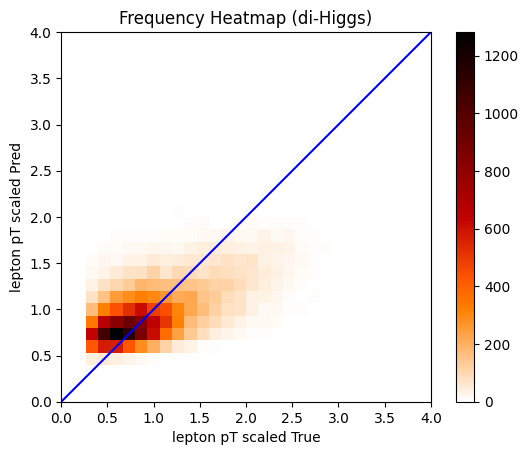

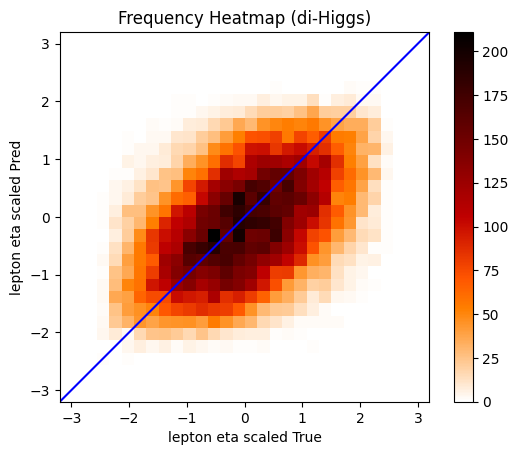

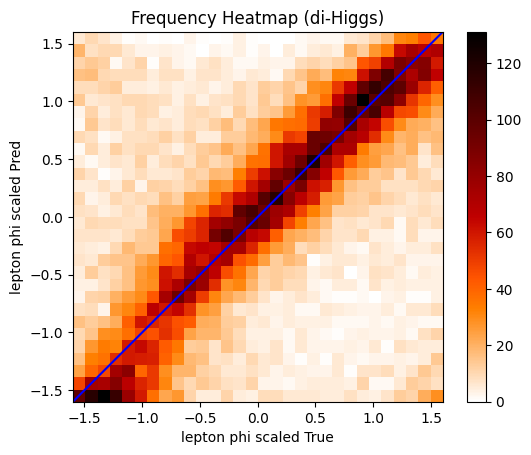

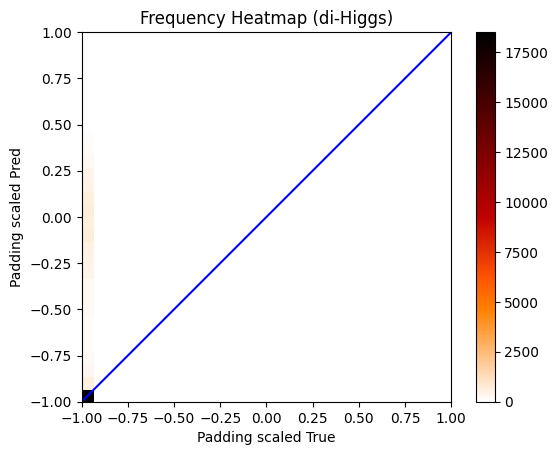

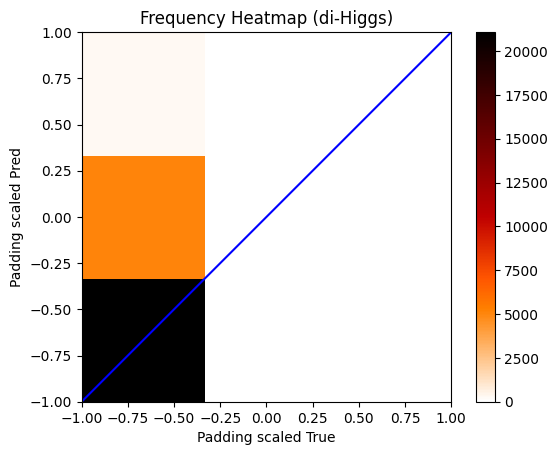

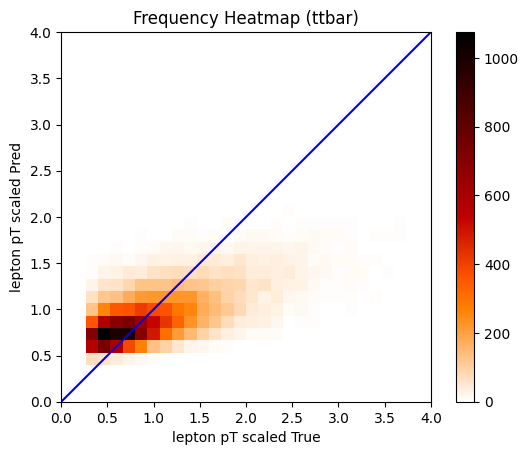

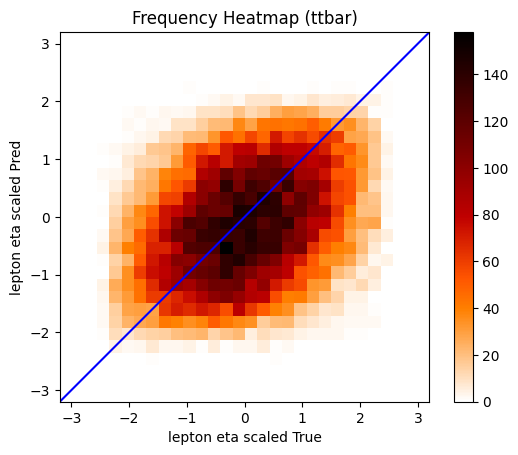

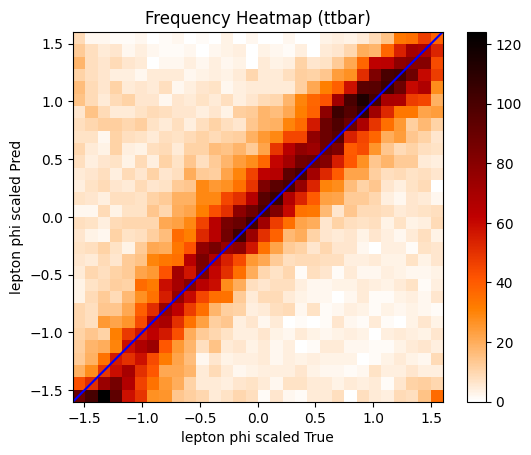

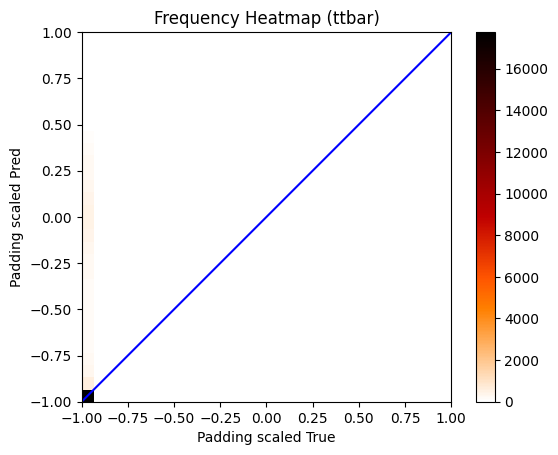

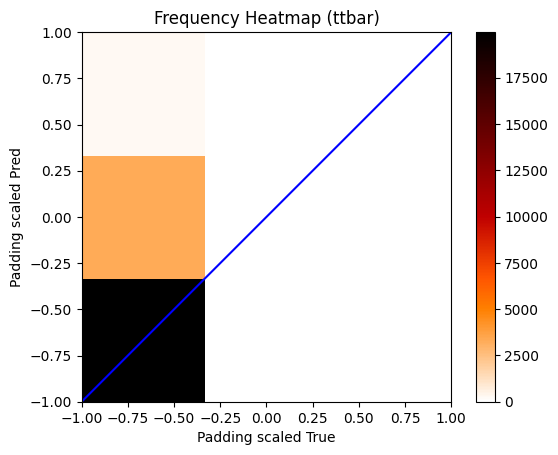

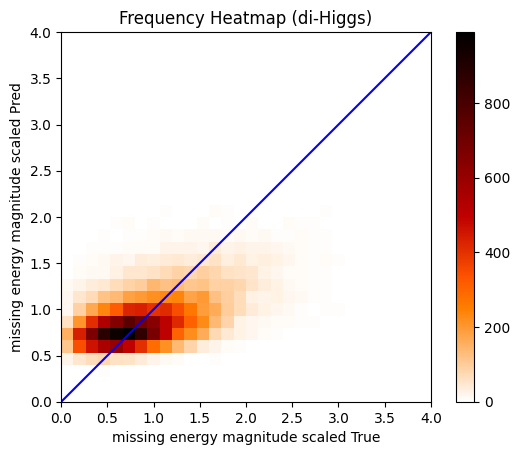

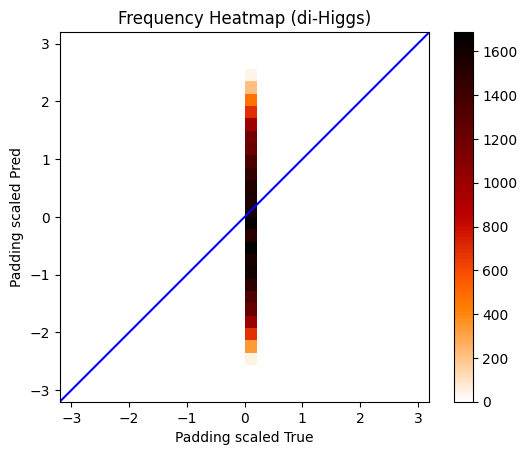

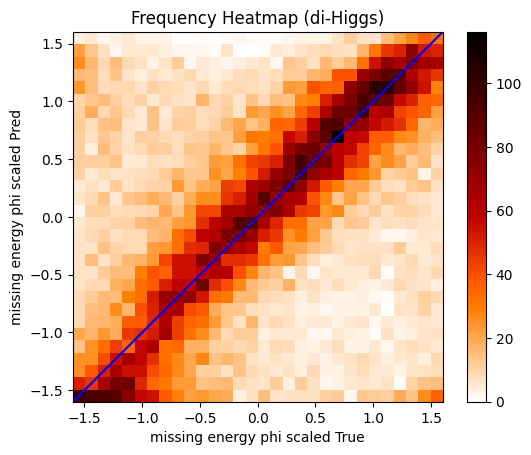

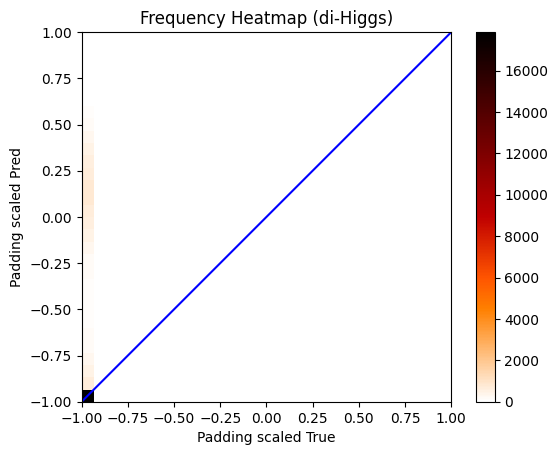

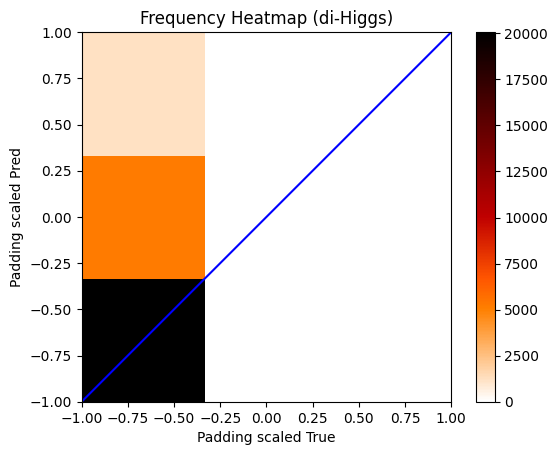

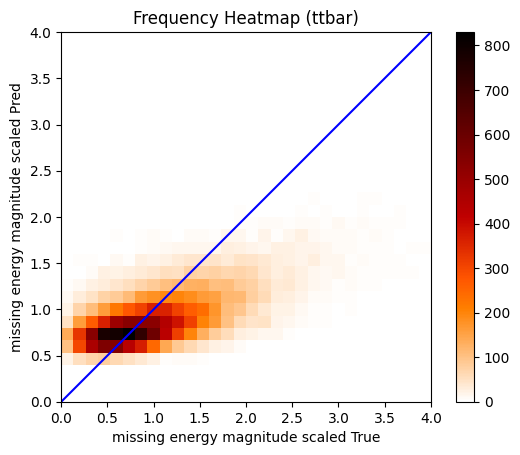

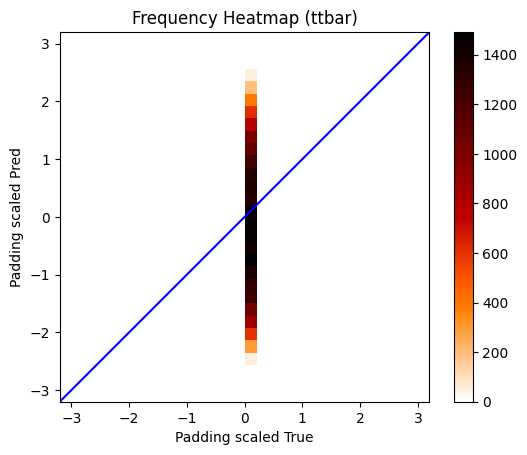

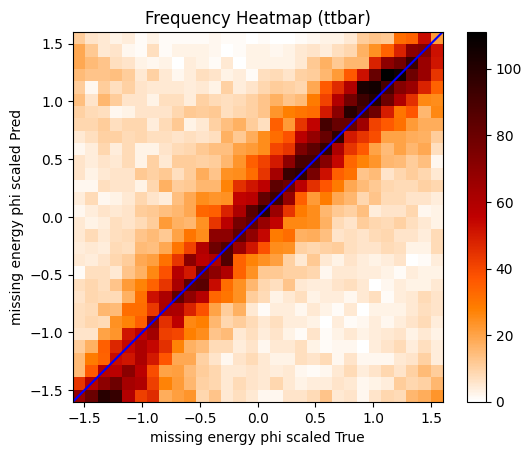

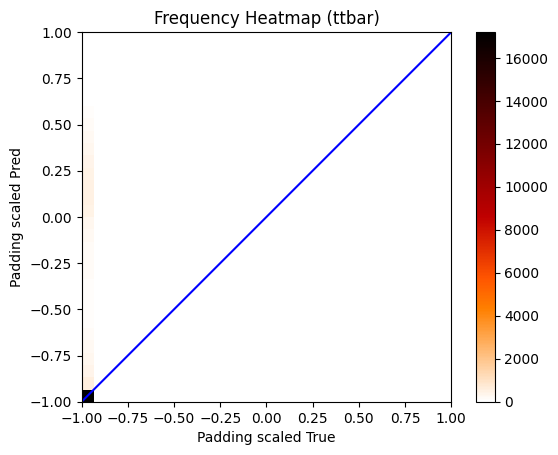

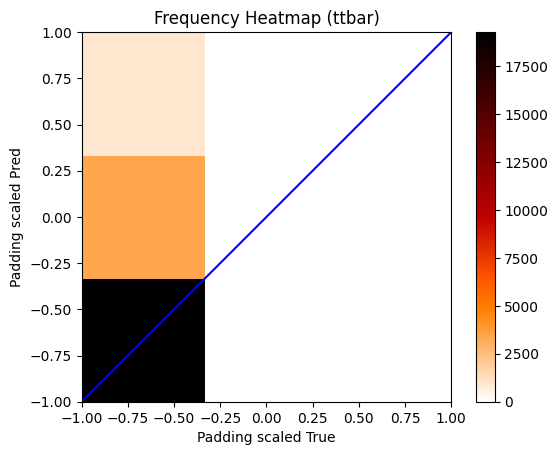

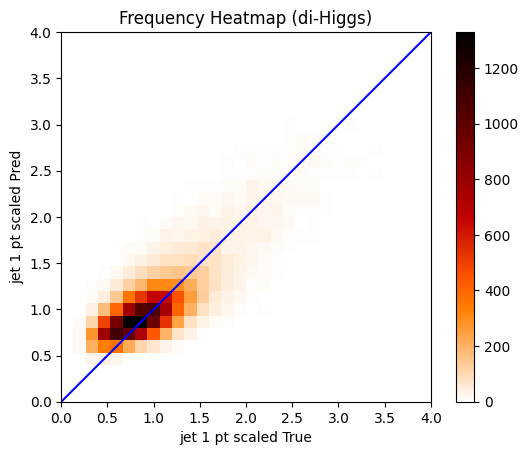

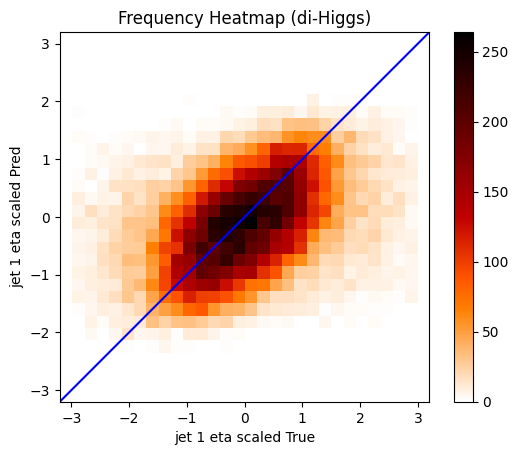

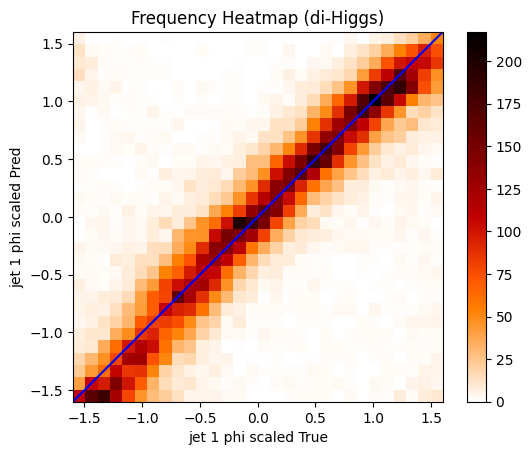

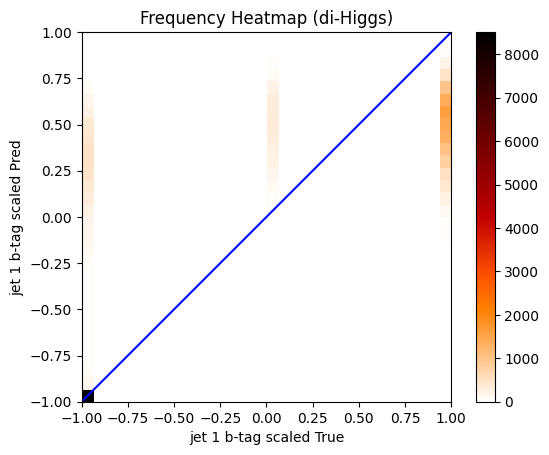

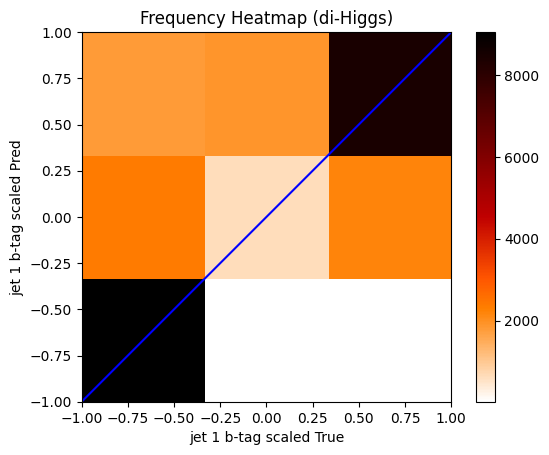

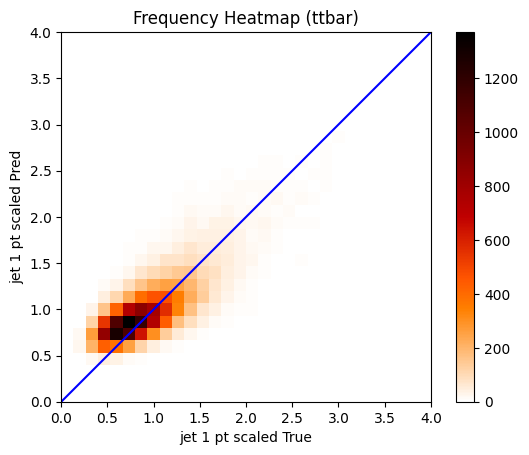

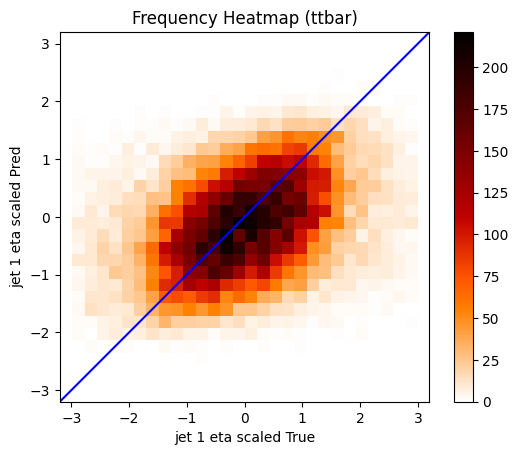

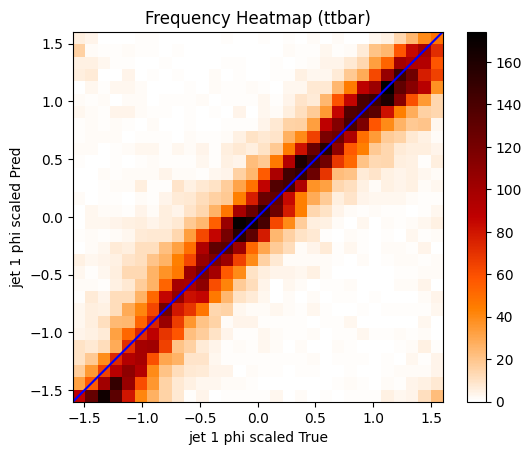

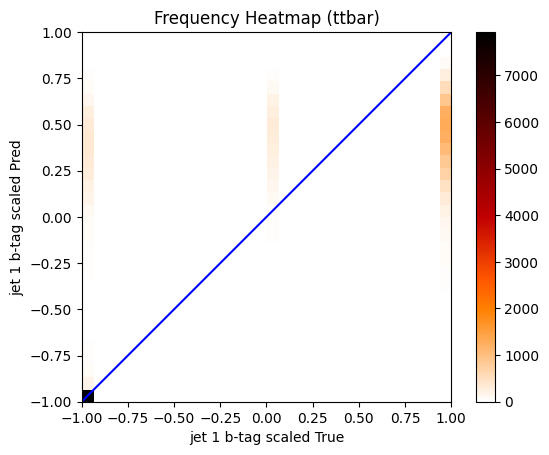

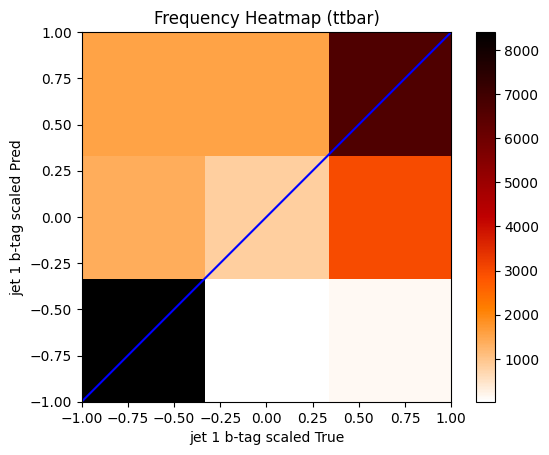

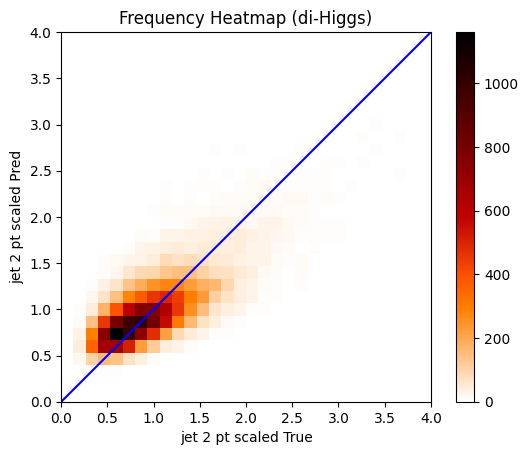

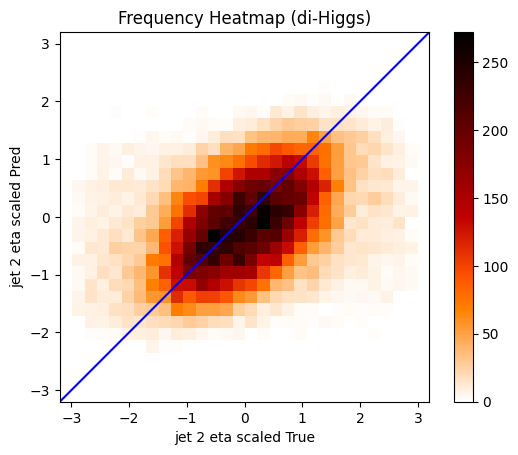

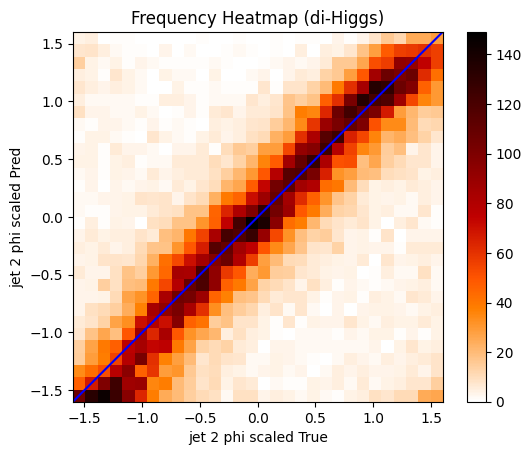

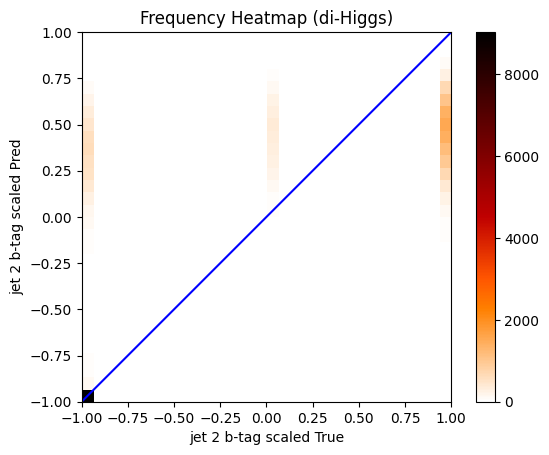

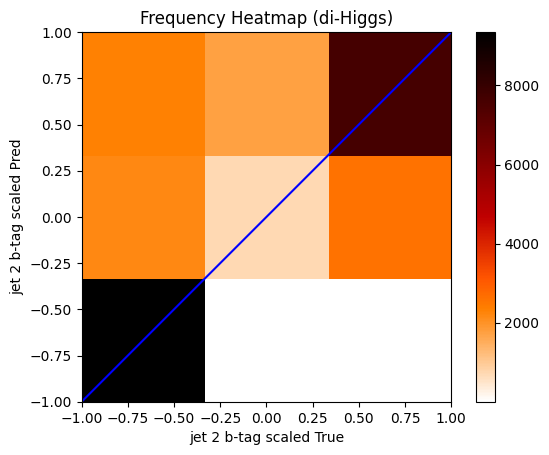

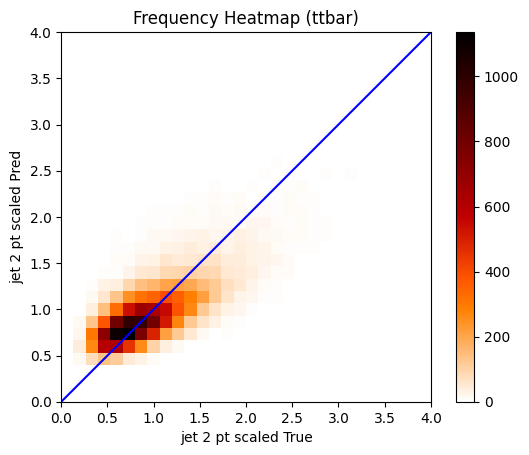

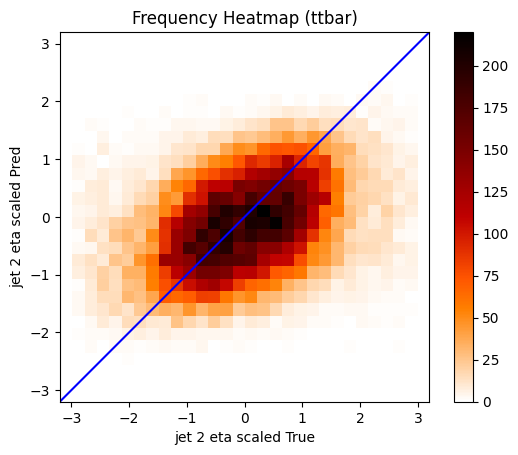

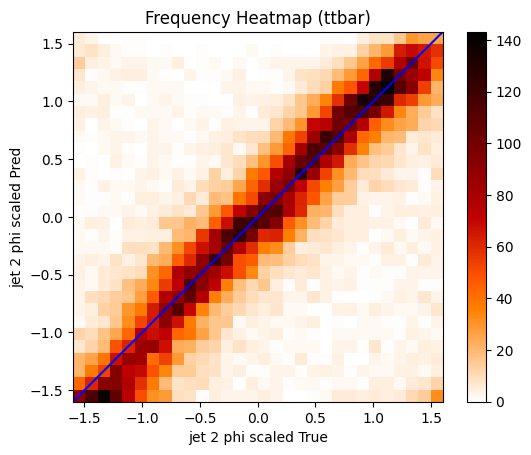

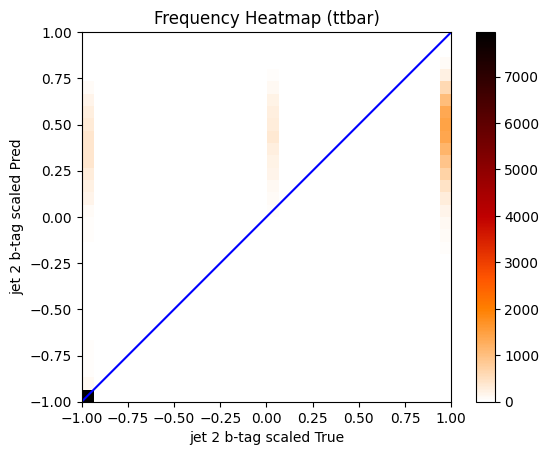

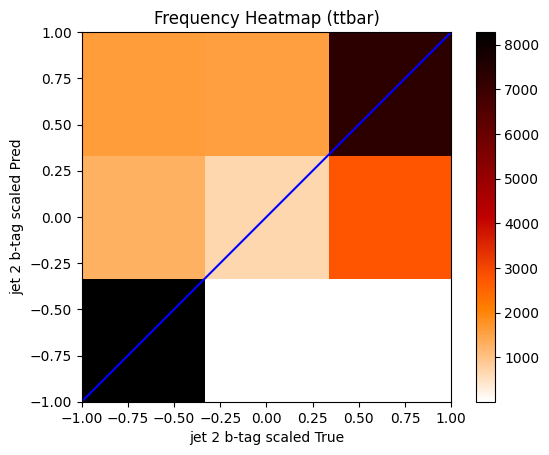

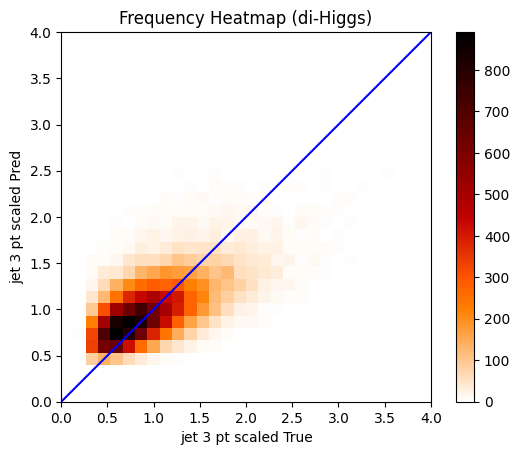

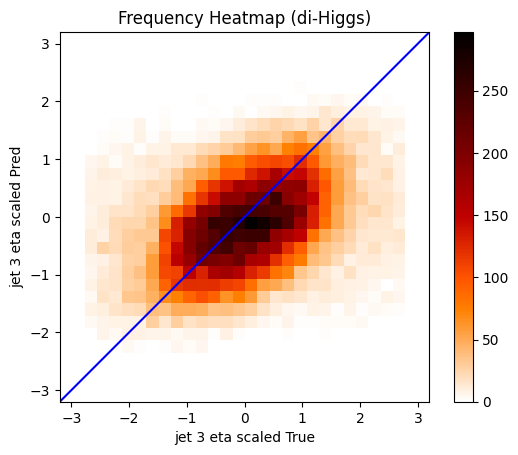

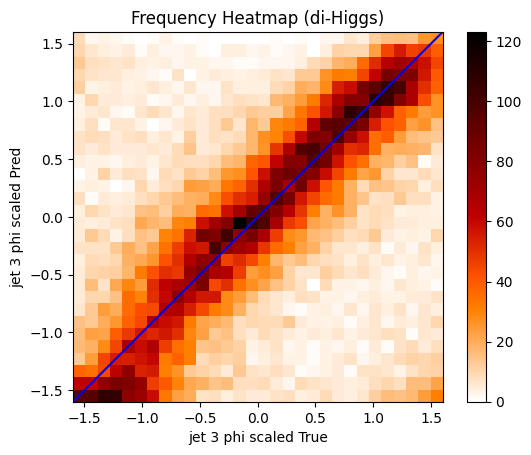

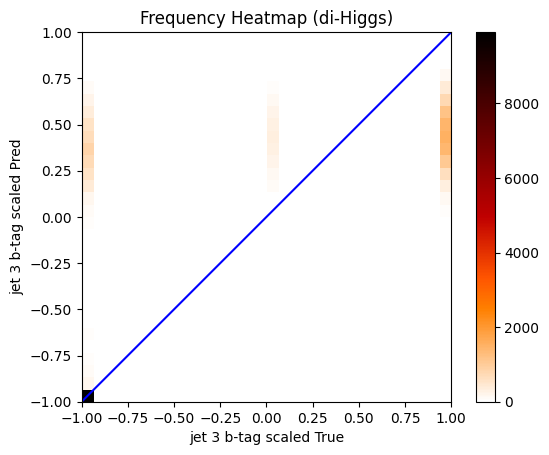

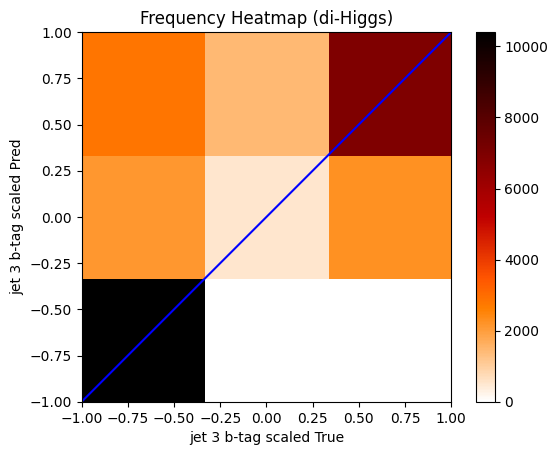

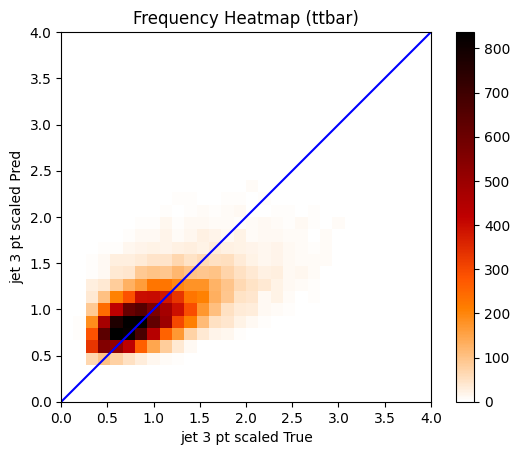

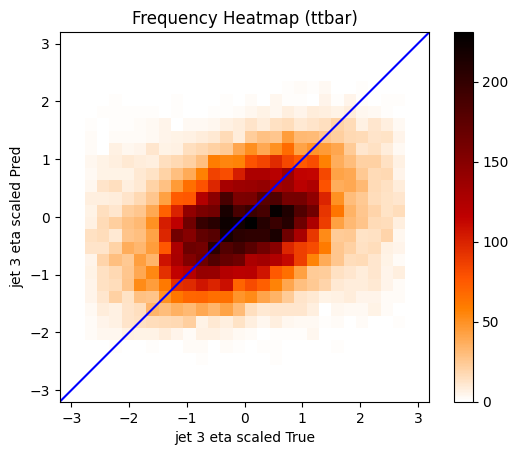

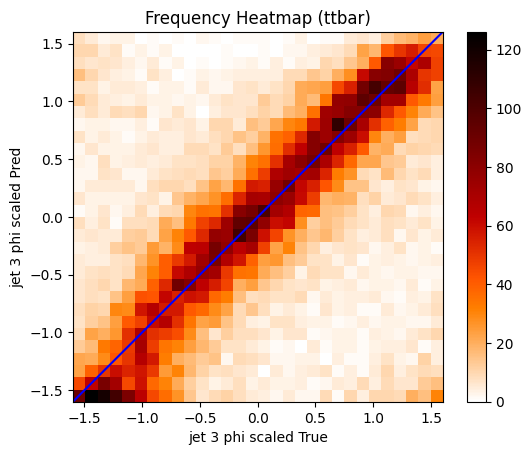

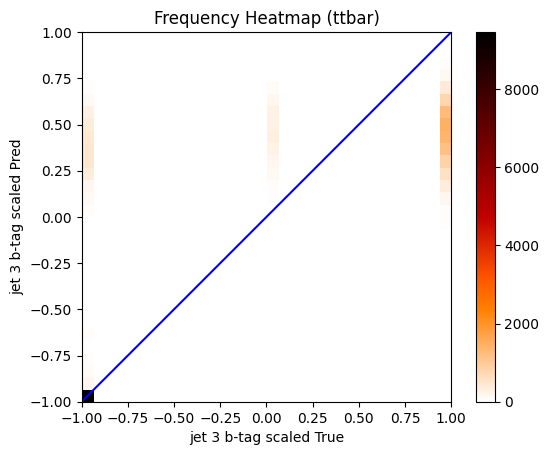

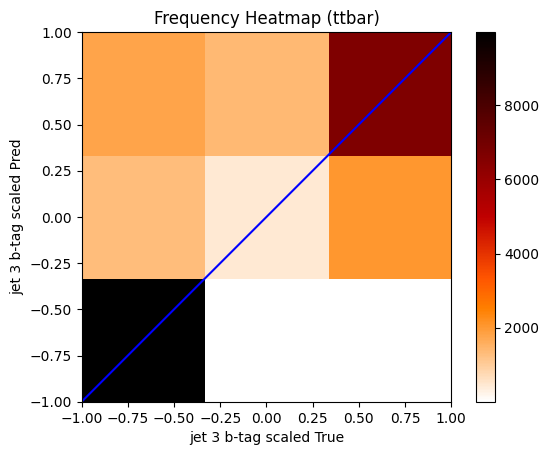

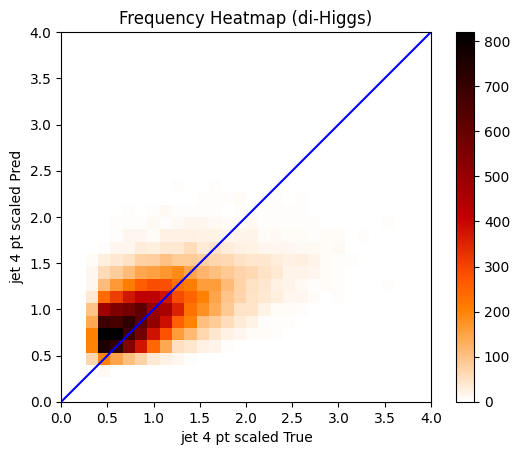

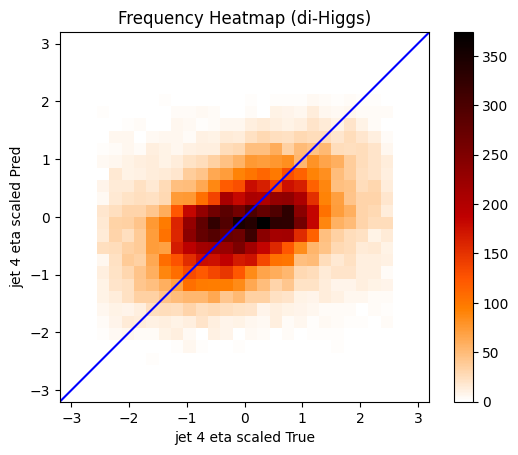

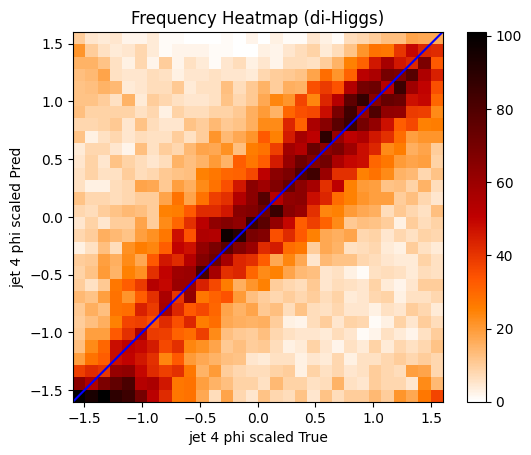

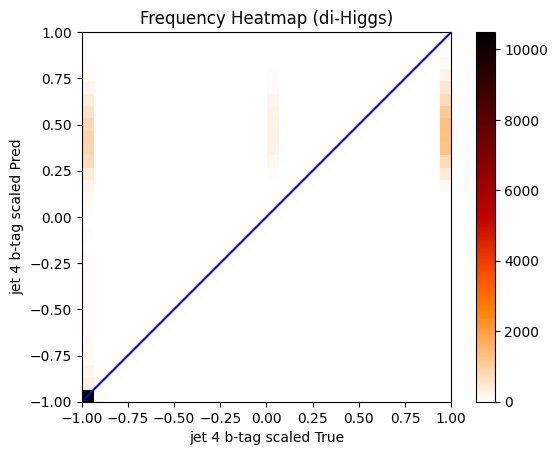

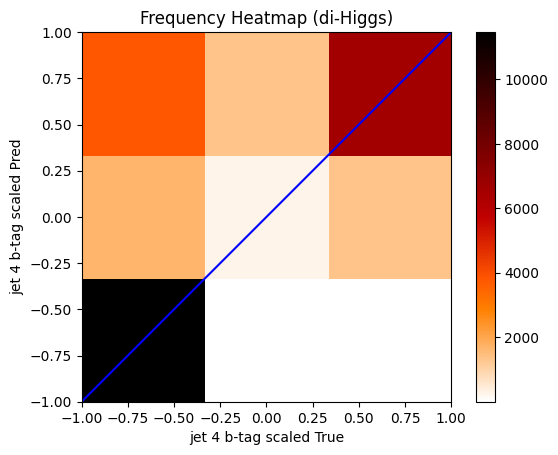

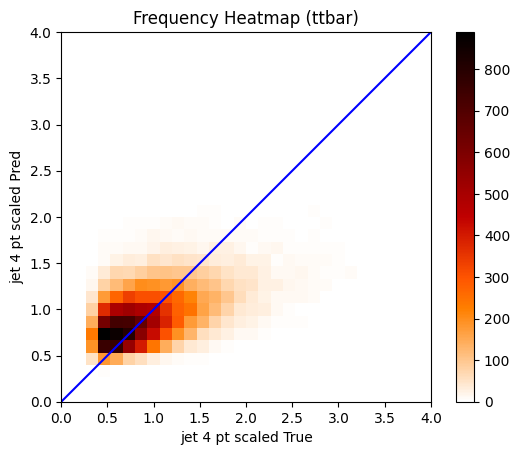

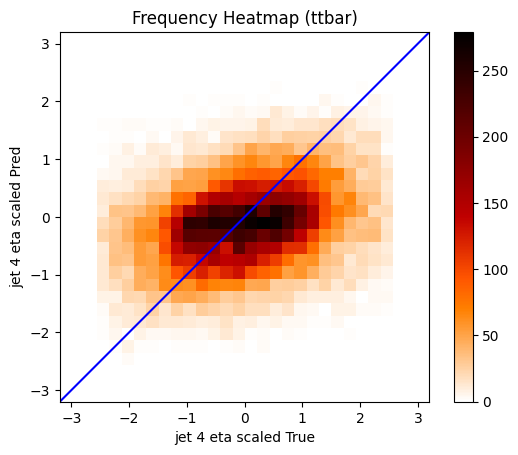

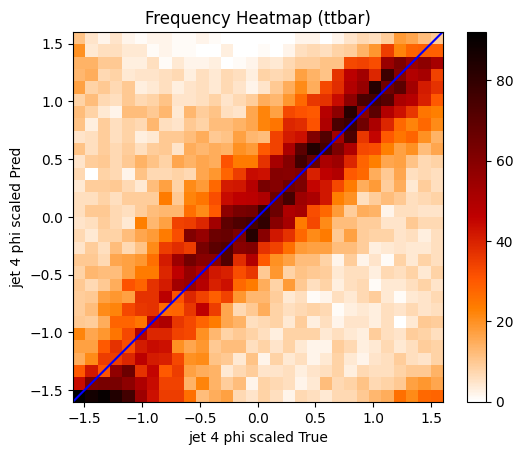

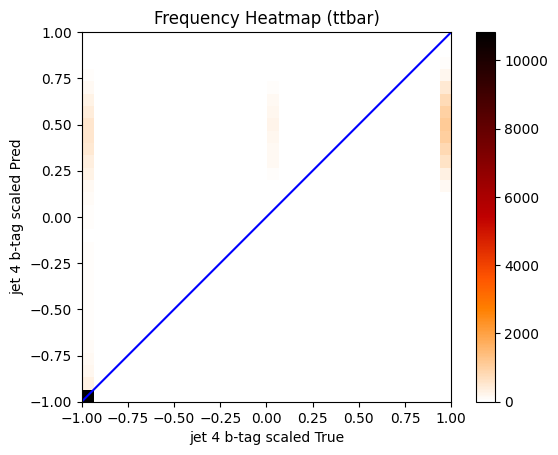

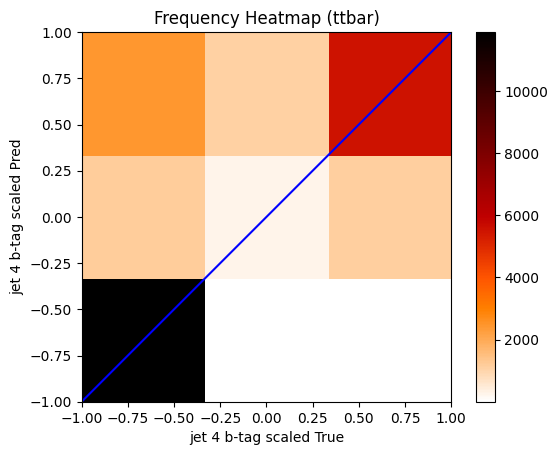

In [55]:
# Test the model and generate some plots
test_and_plot.test(test_loader, config['test_batch_size'], X_test, labels_test, names, [tae], device,
                   config['mask'], x_scaler, config['output_vars'], 'autoencoder', model_name)

# Note: zero-padded values aren't part of the loss function in this demo

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


Classification Accuracy (masked  lepton ):  0.6779864402711946


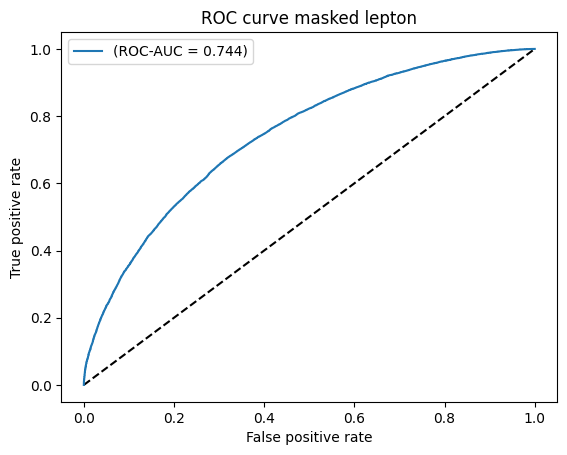

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


Classification Accuracy (masked  missing energy ):  0.7092858142837143


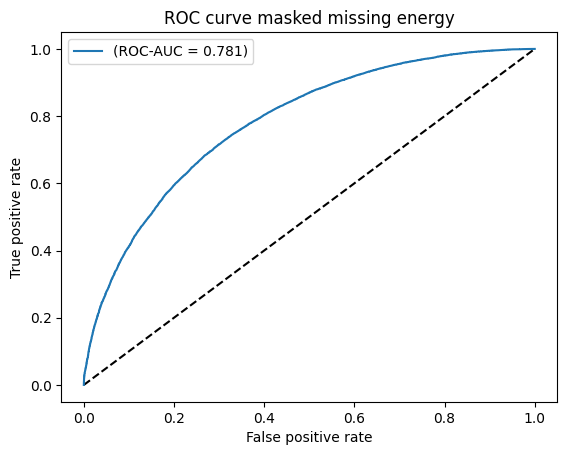

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


Classification Accuracy (masked  jet 1 ):  0.6702665946681067


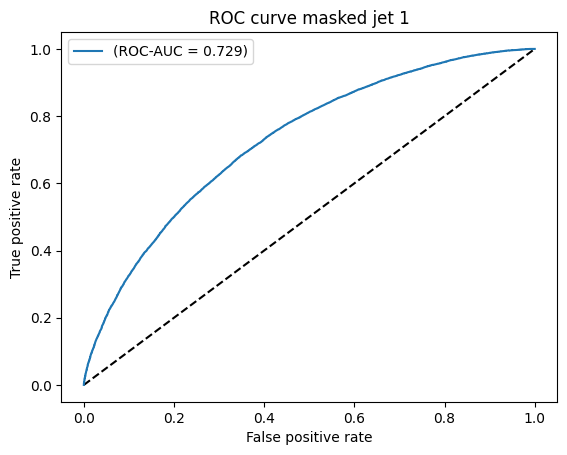

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


Classification Accuracy (masked  jet 2 ):  0.6788664226715466


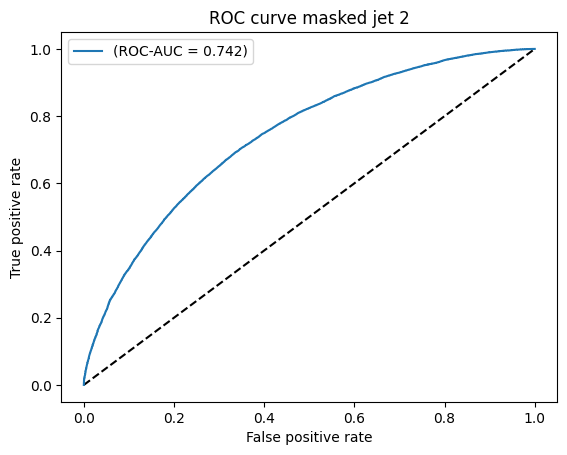

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


Classification Accuracy (masked  jet 3 ):  0.6953060938781225


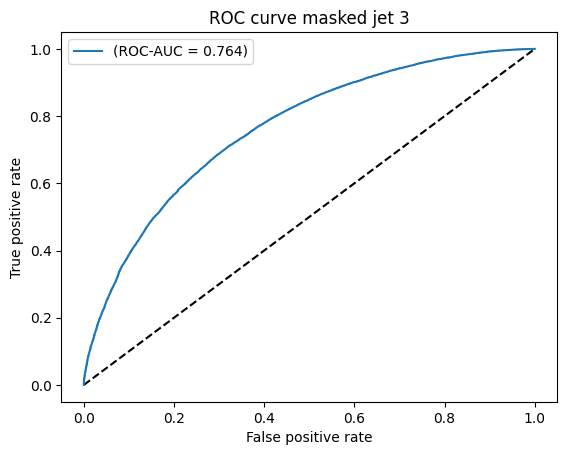

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


Classification Accuracy (masked  jet 4 ):  0.7105657886842263


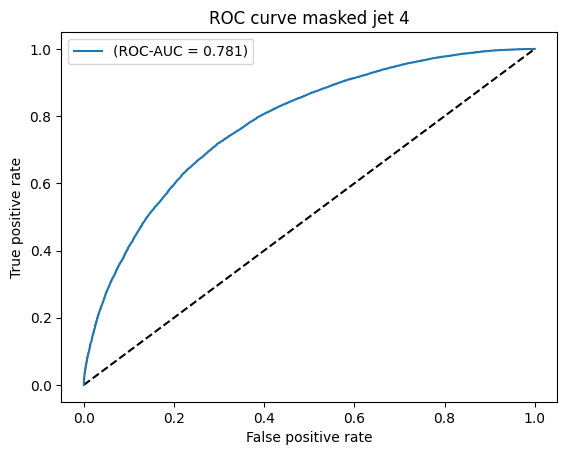

In [56]:
partial_class.load_state_dict(torch.load('./saved_models/uci_higgs/Classifier_partial_best_' + model_name))
test_and_plot.test(test_loader, config['test_batch_size'], X_test, labels_test, names, [tae, partial_class], device,
                   config['mask'], x_scaler, config['output_vars'], 'partial', model_name)

# Note: zero-padded values aren't part of the loss function in this demo

Classification Accuracy (full-information):  0.7021259574808504


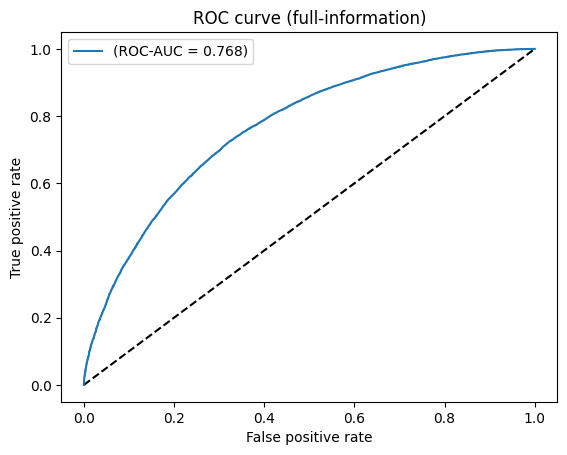

In [59]:
# Test the model and generate some plots
full_class.load_state_dict(torch.load('./saved_models/uci_higgs/Classifier_full_best_' + model_name))
test_and_plot.test(test_loader, config['test_batch_size'], X_test, labels_test, names, [tae, full_class], device,
                   config['mask'], x_scaler, config['output_vars'], 'full', model_name)

# Note: zero-padded values aren't part of the loss function in this demo